In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS, summarize
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import Stepwise, sklearn_selected, sklearn_selection_path


# Question 3 - Exercise 8. In this exercise, we will generate simulated data, and will then use this data to perform forward and backward stepwise selection.

## (a) Create a random number generator and use its `normal()` method to generate a predictor X of length n = 100, as well as a noise vector ϵ of length n = 100

In [3]:
rng = np.random.RandomState(1)
n = 100
X = rng.normal(size=n)
e = rng.normal(scale = 0.1,  size=n)
X

array([ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,
       -2.3015387 ,  1.74481176, -0.7612069 ,  0.3190391 , -0.24937038,
        1.46210794, -2.06014071, -0.3224172 , -0.38405435,  1.13376944,
       -1.09989127, -0.17242821, -0.87785842,  0.04221375,  0.58281521,
       -1.10061918,  1.14472371,  0.90159072,  0.50249434,  0.90085595,
       -0.68372786, -0.12289023, -0.93576943, -0.26788808,  0.53035547,
       -0.69166075, -0.39675353, -0.6871727 , -0.84520564, -0.67124613,
       -0.0126646 , -1.11731035,  0.2344157 ,  1.65980218,  0.74204416,
       -0.19183555, -0.88762896, -0.74715829,  1.6924546 ,  0.05080775,
       -0.63699565,  0.19091548,  2.10025514,  0.12015895,  0.61720311,
        0.30017032, -0.35224985, -1.1425182 , -0.34934272, -0.20889423,
        0.58662319,  0.83898341,  0.93110208,  0.28558733,  0.88514116,
       -0.75439794,  1.25286816,  0.51292982, -0.29809284,  0.48851815,
       -0.07557171,  1.13162939,  1.51981682,  2.18557541, -1.39

## (b) Generate a response vector Y of length n = 100 according to the model $ Y=\beta_{0} + \beta_{1}X + \beta_{2}X^2 + \beta_{3}X^3 + \epsilon $ where $\beta_0, \beta_1, \beta_2$ and $\beta_3$ are constants of your choice.


In [4]:
beta0 = 5
beta1 = 15
beta2 = 3
beta3 = 30
Y = beta0 + beta1 * X - beta2 * np.power(X, 2) + beta3 * np.power(X, 3) + e
Y

array([ 1.49979927e+02, -1.20450532e+01, -8.13937264e+00, -5.15469857e+01,
        3.50687337e+01, -4.11140447e+02,  1.81468606e+02, -2.14839006e+01,
        1.04278176e+01,  6.10931796e-01,  1.14150088e+02, -3.00911358e+02,
       -1.06898621e+00, -2.98867472e+00,  6.19068415e+01, -5.51770399e+01,
        2.16671647e+00, -3.09366230e+01,  5.74225872e+00,  1.87031053e+01,
       -5.51433034e+01,  6.31632789e+01,  3.81988075e+01,  1.57830266e+01,
        3.78248748e+01, -1.61237035e+01,  3.21842900e+00, -3.62123340e+01,
        6.97181419e-02,  1.66731384e+01, -1.67547901e+01, -3.35756423e+00,
       -1.65818340e+01, -2.78799006e+01, -1.54144540e+01,  4.74713583e+00,
       -5.72976626e+01,  8.62338851e+00,  1.58892214e+02,  2.67411735e+01,
        1.78161559e+00, -3.16687557e+01, -2.03081554e+01,  1.67304792e+02,
        5.81125327e+00, -1.35125415e+01,  7.97092698e+00,  3.01263726e+02,
        6.83436550e+00,  2.02369974e+01,  1.00126168e+01, -2.21068568e+00,
       -6.06914436e+01, -

## (c) Use forward stepwise selection in order to select a model containing the predictors $X,X^2, . . . ,X^{10}$. What is the model obtained according to $C_p$? Report the coefficients of the model obtained.

First, we create Dataframe `X_df` contains all the predictors:

In [5]:
X_df = pd.DataFrame({
    'X': X, 'X^2': np.power(X, 2), 'X^3': np.power(X, 3), 'X^4': np.power(X, 4), 'X^5': np.power(X, 5),
    'X^6': np.power(X, 6), 'X^7': np.power(X, 7), 'X^8': np.power(X, 8), 'X^9': np.power(X, 9), 'X^10': np.power(X, 10),
})
print(X_df.head())

          X       X^2       X^3       X^4        X^5        X^6        X^7  \
0  1.624345  2.638498  4.285832  6.961671  11.308158  18.368354  29.836551   
1 -0.611756  0.374246 -0.228947  0.140060  -0.085683   0.052417  -0.032066   
2 -0.528172  0.278965 -0.147342  0.077822  -0.041103   0.021710  -0.011466   
3 -1.072969  1.151262 -1.235268  1.325403  -1.422116   1.525886  -1.637228   
4  0.865408  0.748930  0.648130  0.560897   0.485404   0.420073   0.363534   

         X^8        X^9        X^10  
0  48.464863  78.723675  127.874436  
1   0.019617  -0.012001    0.007342  
2   0.006056  -0.003199    0.001689  
3   1.756694  -1.884878    2.022415  
4   0.314605   0.272262    0.235617  


We then reused the following function to calculate the $C_p$ statistic in Lab section. After that we performed Forward selection. The selected predictors are $X$, $X^2$, $X^3$ and $X^6$. We also present the oefficients of the model obtained.

In [6]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

design = MS(X_df.columns).fit(X_df)
X_transformed = design.transform(X_df)
sigma2 = OLS(Y,X_transformed).fit().scale
neg_Cp = partial(nCp, sigma2)

strategy = Stepwise.first_peak(design, direction="forward", max_terms=len(design.terms))

X_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
X_Cp.fit(X_df, Y)
print("Selected predictors: ", X_Cp.selected_state_)
print("Coefficients of the model:")
print(summarize(X_Cp.results_))

Selected predictors:  ('X', 'X^2', 'X^3', 'X^6')
Coefficients of the model:
              coef  std err         t  P>|t|
intercept   5.0277    0.013   393.160  0.000
X          14.9910    0.018   821.191  0.000
X^2        -3.0343    0.017  -176.651  0.000
X^3        30.0105    0.006  4679.624  0.000
X^6         0.0021    0.001     2.443  0.016


## (d) Repeat (c), using backwards stepwise selection. How does your answer compare to the results in (c)?

The result of backward selections is similar to that of forward selection. The selected predictors include $X, X^2, X^3, X^6$

In [7]:
strategy = Stepwise.first_peak(design, direction="backward", initial_terms=design.terms)
X_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
X_Cp.fit(X_df, Y)
print("Selected predictors: ", X_Cp.selected_state_)
print("Coefficients of the model:")
print(summarize(X_Cp.results_))

Selected predictors:  ('X', 'X^2', 'X^3', 'X^6')
Coefficients of the model:
              coef  std err         t  P>|t|
intercept   5.0277    0.013   393.160  0.000
X          14.9910    0.018   821.191  0.000
X^2        -3.0343    0.017  -176.651  0.000
X^3        30.0105    0.006  4679.624  0.000
X^6         0.0021    0.001     2.443  0.016


## (e) Now fit a lasso model to the simulated data, again using $X, X^2,...,X^{10}$ as predictors. Use cross-validation to select the optimal value of $\lambda$. Create plots of the cross-validation error as a function of $\lambda$. Report the resulting coefficient estimates, and discuss the results obtained

We applied Lasso with cross-validation (5 folds) to select $\lambda$. With the selected model, we investigate the predictors with the coefficient different than 0. As can be seen, 4 predictors $X$, $X^2$, $X^3$, $X^5$ are selected with the smallest Cross Validated MSE of 0.06980 with $\lambda = 0.0872$ 

Selected features:  Index(['X', 'X^2', 'X^3', 'X^5'], dtype='object')
Optimal lambda:  0.08720745243316805
Min MSE:  0.06980303251169206


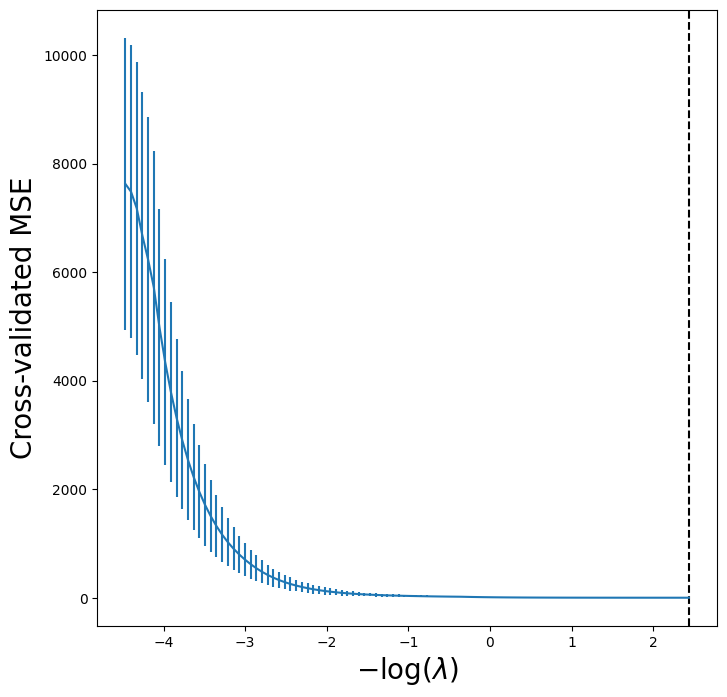

In [8]:
scaler = StandardScaler(with_mean=True,  with_std=True)
kfold = skm.KFold(n_splits=5, shuffle=True, random_state=2)
mse_fig, ax = subplots(figsize=(8,8));
lassoCV = skl.ElasticNetCV(n_alphas=100, l1_ratio=1,cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])
pipeCV.fit(X_df, Y)
tuned_lasso = pipeCV.named_steps['lasso']
print("Selected features: ", X_df.columns[tuned_lasso.coef_ != 0])
print("Optimal lambda: ", tuned_lasso.alpha_)

# Plot the result.
ax.errorbar(-np.log(tuned_lasso.alphas_), tuned_lasso.mse_path_.mean(1), yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(5))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);
print("Min MSE: ", tuned_lasso.mse_path_.mean(1).min())

## (f) Now generate a response vector Y according to the model $Y = \beta_0 + \beta_7X^7 + \epsilon$, and perform forward stepwise selection and the lasso. Discuss the results obtained.

We generate Y using $\beta_0 = 5$ and $\beta_1=30$ 
- Using forward selection, the predictors selected are $X^{10}, X^2, X^7$. We can see that the coefficient of $X^7$ is 30.0004 which is close to the actual $\beta_7$. The estimation of intercept of 5.0229 is also close to $\beta_0 = 5$. Small P_value of $X^7$ indicates that it should be included in our model.
- Using Lasso, $X, X^5, X^7, X^9, X^{10}$ are selected. However we can observe that the coefficients do not match the true cofficients of the model.

In [9]:
beta0 = 5
beta7 = 30
Y_new = beta0 + beta7 * np.power(X, 7) + e

In [10]:
design = MS(X_df.columns).fit(X_df)
X_transformed = design.transform(X_df)
sigma2 = OLS(Y_new,X_transformed).fit().scale
neg_Cp = partial(nCp, sigma2)

forward_strategy = Stepwise.first_peak(design, direction='forward', max_terms=len(design.terms), )
forward_Cp = sklearn_selected(OLS, forward_strategy, scoring=neg_Cp)
forward_Cp.fit(X_transformed, Y_new)
forward_Cp.selected_state_
print(summarize(forward_Cp.results_))

                coef   std err           t  P>|t|
intercept   5.022900  0.012000     412.965  0.000
X^10        0.000064  0.000029       2.235  0.028
X^2        -0.019100  0.013000      -1.460  0.147
X^7        30.000400  0.000000  153000.000  0.000


Intercept:  -9.187708274060649
X:  -7.209973714201441
X^5:  249.34471343399375
X^7:  965.7193030438101
X^9:  314.77115083088785
X^10:  2.1129352152854732


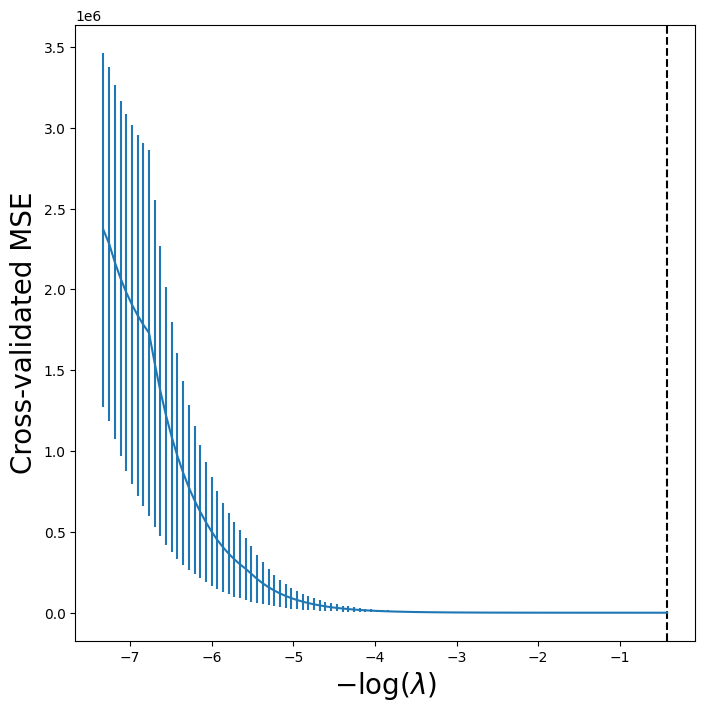

In [11]:
mse_fig, ax = subplots(figsize=(8,8));
lassoCV = skl.ElasticNetCV(n_alphas=100,  l1_ratio=1, cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])
pipeCV.fit(X_df, Y_new)
tuned_lasso = pipeCV.named_steps['lasso']
print("Intercept: ", tuned_lasso.intercept_)

for predictor, c in zip(X_df.columns[tuned_lasso.coef_ != 0].to_list(), tuned_lasso.coef_[tuned_lasso.coef_ != 0]):
    print(f"{predictor}:  {c}")

ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(5))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);
# print("Min MSE: ", tuned_lasso.mse_path_.mean(1).min())

# Question 3 - Exercise 9: In this exercise, we will **predict the number of applications received** using the other variables in the College data set.

College dataset has one qualitative feature **Private** with 2 values Yes or No

In [12]:
College = load_data('College')
College['Private'] = pd.Categorical(College['Private'])

## (a) Split the data set into a training set and a test set.

We use 25% of all samples for testing (`College_test`), 75% for training (`College_train`).

In [13]:
from sklearn.model_selection import train_test_split
College_train, College_test = train_test_split(College, test_size=0.25, random_state=0)

## (b) Fit a linear model using least squares on the training set, and report the test error obtained.

We apply least squares to only the samples in the training set `College_train` to train the model and use the model to make predictions on test set. The test error in term of Mean square error is **1022430.0889**

In [14]:
allvars = list(College_train.columns.drop('Apps'))
y = College_train['Apps']
mm = MS(allvars)
X_transformed = mm.fit_transform(College_train)
model = OLS(y, X_transformed)
results = model.fit()

We now predict the `Apps` variable using the model and calculate the Mean Square Error on the test set `College_test`

In [15]:
X_test = mm.transform(College_test)
y_test = College_test['Apps']
y_test_pred = results.predict(X_test)
ls_result = np.mean((y_test - y_test_pred.ravel())**2)
print("Test error obtained (MSE of linear model using squares regression on test set): ", ls_result)

Test error obtained (MSE of linear model using squares regression on test set):  1022430.0889254622


## (c) Fit a ridge regression model on the training set, with λ chosen by cross-validation. Report the test error obtained.

In [16]:
scaler = StandardScaler(with_mean=True,  with_std=True)
kfold = skm.KFold(n_splits=5, shuffle=True, random_state=0)
X = mm.transform(College_train).drop('intercept', axis=1)
X_test = mm.transform(College_test).drop('intercept', axis=1)
y_test = College_test['Apps']

We will use the function `RidgeCV`, which is ridge regression with 5-fold cross-validation to find the the optimal $\lambda$. Finally, we use the resulted model to make prediction on the test set.

In [17]:
lambdas = 10**np.linspace(8, -2, 100) / y.std()
ridgeCV = skl.ElasticNetCV(alphas=lambdas, cv=kfold, l1_ratio=0, verbose=False)
ridgePipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)]);
ridgePipeCV.fit(X, y);
print("Best Lambda for Ridge: ", ridgeCV.alpha_)
y_pred = ridgePipeCV.predict(X_test)
ridge_result = np.mean((y_test - y_pred.ravel())**2)
print("Test error obtained (MSE of Ridge regression on test set): ", ridge_result)


Best Lambda for Ridge:  2.4587830103570054e-06
Test error obtained (MSE of Ridge regression on test set):  1022416.8993186272


## (d) Fit a lasso model on the training set, with λ chosen by cross-validation. Report the test error obtained, along with the number of non-zero coefficient estimates.

We used the same process of Ridge Regression for Lasso. `LassoCV` was utilized to find optimal $\lambda$ with 5-fold cross-validation. The best model is used to make prediction on the test set. As can be observed the number of non-zero coefficients is 12 out of 17.

In [18]:
lassoCV = skl.ElasticNetCV(n_alphas=100, cv=kfold, l1_ratio=1)
pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)]);
pipeCV.fit(X, y);
print("Best Lambda for Lasso: ", pipeCV.named_steps['lasso'].alpha_)
tuned_lasso = pipeCV.named_steps['lasso']
y_pred = pipeCV.predict(X_test)
lasso_result = np.mean((y_test - y_pred.ravel())**2)
print("Test error obtained (MSE of Lasso regression on test set): ", lasso_result)
print("Non-zero coefficient estimates: ", X.columns[tuned_lasso.coef_ != 0])
print("The number of non-zero coefficient estimates.: ", len(X.columns[tuned_lasso.coef_ != 0]), 'predictors out of', len(X.columns))

Best Lambda for Lasso:  27.19057396544297
Test error obtained (MSE of Lasso regression on test set):  1016583.3530579971
Non-zero coefficient estimates:  Index(['Private[Yes]', 'Accept', 'Enroll', 'Top10perc', 'Top25perc',
       'P.Undergrad', 'Outstate', 'Room.Board', 'PhD', 'Terminal', 'Expend',
       'Grad.Rate'],
      dtype='object')
The number of non-zero coefficient estimates.:  12 predictors out of 17


## (e) Fit a PCR model on the training set, with M chosen by crossvalidation. Report the test error obtained, along with the value of M selected by cross-validation.

In [19]:
pipe = Pipeline([('scaler', scaler), ('pca', PCA()), ('linreg', skl.LinearRegression())])
param_grid = {'pca__n_components': range(1, 18)}
grid = skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X, y)
print("Best M: ", grid.best_params_["pca__n_components"])
y_pred = grid.predict(X_test)
pcr_result = np.mean((y_test - y_pred.ravel())**2)
print("Test error obtained (MSE of PCR on test set):", pcr_result)

Best M:  17
Test error obtained (MSE of PCR on test set): 1022430.0889255435


## (f) Fit a PLS model on the training set, with M chosen by crossvalidation. Report the test error obtained, along with the value of M selected by cross-validation.

In [20]:
param_grid = {'n_components':range(1, 18)}
grid = skm.GridSearchCV(PLSRegression(scale=True), param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X, y);
print("Best M: ", grid.best_params_['n_components'])
y_pred = grid.predict(X_test)
pls_result = np.mean((y_test - y_pred.ravel())**2)
print("Test error obtained (MSE of PLS on test set):", pls_result)


Best M:  11
Test error obtained (MSE of PLS on test set): 1028278.2408135456


## (g) Comment on the results obtained. How accurately can we predict the number of college applications received? Is there much difference among the test errors resulting from these five approaches?

The following table contains all the mean square error for 5 methods sorted in increasing order. Lasso regression gives us the smallest MSE. Ridge regression, Least square and PCR have the approximately the same error while PLS has the highest error 

In [21]:
result_combined = pd.DataFrame({
    "Models": ["Least Square", "Lasso Regression", "Ridge Regression", "PCR", "PLS"],
    "Test set MSE": [round(ls_result, 2), round(lasso_result, 2), round(ridge_result, 2), round(pcr_result, 2), round(pls_result, 2)]
})
print(result_combined.sort_values("Test set MSE"))

             Models  Test set MSE
1  Lasso Regression    1016583.35
2  Ridge Regression    1022416.90
0      Least Square    1022430.09
3               PCR    1022430.09
4               PLS    1028278.24


In [22]:
!jupyter nbconvert --output-dir './Q3' 'A3-Q3.ipynb' --to latex

[NbConvertApp] Converting notebook A3-Q3.ipynb to latex
[NbConvertApp] Support files will be in A3-Q3_files/
[NbConvertApp] Writing 70399 bytes to Q3/A3-Q3.tex
